In [2]:
#library
import pandas as pd
import json

import numpy as np
import matplotlib as plt
import seaborn as sns

import time
from datetime import datetime


In [3]:
#load data

# loop through files in folder. For test case work with 1 file

file1 = "Arbsnapshot/proposal0to20.json"
with open (file1, "r")  as f:
    all_data = json.loads(f.read()) 

df = pd.DataFrame.from_dict(all_data)

In [4]:
df.head()

# clean up: 
# TODO: proposal: keep only proposal id. right now it's a dictionary item

voter          vp     created  \
0  0x8847EBaaf29A18396e49191602f8d8D141b98aa7  115.342190  1707436428   
1  0x76154852f74Fb77012d50eedA7D35eA6b2bc3ba9  151.397176  1707436448   
2  0x2cf993715CbA5b83c9a26755EdD42445E900205C    1.127696  1707436497   
3  0x92CBe89B5Cb1c22c2c16Bc465CaF34E3c80b617D    2.053495  1707436516   
4  0x40Fd572771ce7f3B3AFc51e05C2C8288E7d96e5d    1.074772  1707436531   

                                            proposal choice  \
0  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   
1  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   
2  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   
3  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   
4  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   

                              space  
0  {'id': 'arbitrumfoundation.eth'}  
1  {'id': 'arbitrumfoundation.eth'}  
2  {'id': 'arbitrumfoundation.eth'}  
3  {'id': 'arbitrumfoundation.eth'}  
4  {'id': 'arbitrumfoundation.eth'}

In [5]:
df.dtypes
# why is choice an object? --> for some votes people pick more than 1 chocie

voter        object
vp          float64
created       int64
proposal     object
choice       object
space        object
dtype: object

In [6]:
# fix proposal field
df['prop'] = [d.get('id') for d in df.proposal]
# df = df.drop('proposal')

In [7]:
# fix choice column
type(df.choice[1])
# df['choice'].astype(str).astype(int) --> can't transform as its dict
# df['choice2'] = [int(s) for s in df.choice]

int

# Governance participation analysis for Snapshot

Participation Rate Analytics: Conduct in-depth analytics to assess and analyze participation rates in on-chain voting, identifying trends, patterns, and potential areas for improvement.

## Overall descriptives

- how many unique voters
- how many proposals
- average times someone votes
- range of times someone votes --> histogram
- proposal: proposal with lowest/highest amount of votes
- messari on-chaing governance participation rate

### Overall description: Voting frequency

In [8]:
# number unique voters
print("Number of unique voters: ", len(df.voter.unique()))

Number of unique voters:  88157


<Axes: ylabel='Count'>

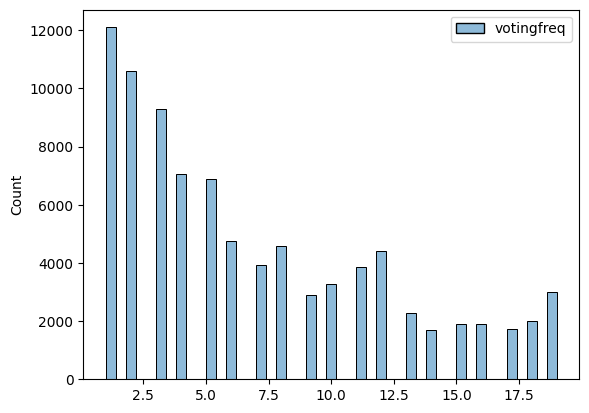

In [9]:
# df summary grouped by voter

# df.groupby('voter').describe() # 4 min for 20 proposals

# number of times a person voted
# TODO: rename column from vp to voter frequency
votefreq = df[['voter', 'vp']].groupby('voter', as_index=False).agg('count')
votefreq = votefreq.rename(columns={'vp':'votingfreq'})
sns.histplot(votefreq)


In [10]:
# description of voting frequency
votefreq.describe()


votingfreq
count  88157.000000
mean       6.867498
std        5.269709
min        1.000000
25%        2.000000
50%        5.000000
75%       11.000000
max       19.000000

### Overall description: Proposal frequency

In [11]:
# number unique voters
print("Number of proposals: ", len(df.prop.unique()))

Number of proposals:  19


<Axes: ylabel='Count'>

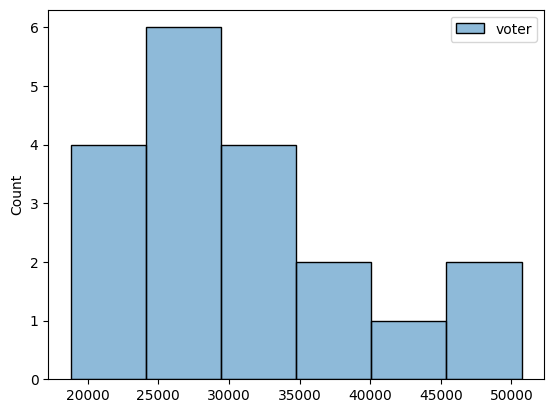

In [12]:
# popularity contest of proposals --> in final report can add screenshot of that proposal

#proposal: proposal with lowest/highest amount of votes
proposalfreq = df[['prop', 'voter']].groupby('prop', as_index = False).count()
proposalfreq = proposalfreq.rename(columns={'vp':'freq'})
proposalfreq
# Plot: Proposal popularity: How many times did X amount of people vote on a proposal
# Bot the best graphic as the number of votes a proposal got is lumped together. There were 19 proposal and the graph shows 6 bars. Histogram makes up 19
sns.histplot(proposalfreq)


In [13]:
#proposal that got most yes/no/abstain votes  => can't do this without knowing for sure if the 3 choices are yes/no/abstain

# proposalfreq = df[['prop', 'voter', 'choice']].groupby(['prop', 'choice'], as_index = False).count()
# proposalfreq
# proposalfreq = proposalfreq.rename(columns={'vp':'tot_voters'})
# sns.histplot(proposalfreq)

In [14]:
#proposal: proposal with lowest/highest amount of votes
maxvotes = max(proposalfreq['voter'])
maxvotesprop = proposalfreq.loc[proposalfreq['voter'] == maxvotes, 'prop'].values[0]
print("The proposal {proposal} got most votes ({votes} votes).".format(proposal = maxvotesprop, votes = maxvotes))

minvotes = min(proposalfreq['voter'])
minvotesprop = proposalfreq.loc[proposalfreq['voter'] == minvotes, 'prop'].values[0]
print("The proposal {proposal} got the least amount of votes ({votes} votes).".format(proposal = minvotesprop, votes = minvotes))

The proposal 0xa635e39a2c527f7a1eabf5ea22bdec6f4a265d6c69a06076e65fde0ae0a5941b got most votes (50718 votes).
The proposal 0xf49d88ec2f4fa7373efc66a7cf9441d916519f48a2d90e7db3ea688357150a44 got the least amount of votes (18800 votes).


### Governance Participation Rate

Messari on-chaing governance participation rate (the sum of voting power that has ever voted in an on-chain proposal divided by total on-chain delegated voting power)

TODO: to run that we need total on-chain delegated voting power for each last block of a proposal

## Evolution of voting participation

In [15]:
# voter, blocktime

# convert timestamp to time
df['time'] = [datetime.fromtimestamp(s) for s in df.created]
# df[['time', 'created']].head()

# df[['created', 'voter', 'prop', 'vp']].head()

#length of time between first and last vote
df['rank'] = df.groupby('voter')['time'].rank(method='first', ascending = True)

#filter for first and last entry in each group
df2 = df[['voter', 'time']].groupby('voter', as_index=False).agg('count').reset_index()
df2 = df2.rename(columns = {'time':'freq'})


In [16]:
# df2.head()

In [17]:
df3 = df[['voter', 'time']].groupby('voter').agg(first_date = ('time', 'min'),last_date = ('time', 'max')).reset_index()
df3['time_active'] = df3['last_date'] - df3['first_date']
# df3

In [18]:
timelag = df2.set_index('voter').join(df3.set_index('voter'))

In [19]:
timelag.head()

index  freq          first_date  \
voter                                                                         
0x000000000A38444e0a6E37d3b630d7e855a7cb13      0     3 2023-12-10 18:19:56   
0x00000001B01122945D67Cf7c972f1a2063Ca4008      1     1 2023-11-13 22:14:24   
0x0000000452Bbfc5541279949E5e9400821A0C92d      2     1 2023-11-13 21:54:50   
0x0000000AfEAF433D80183Ee49b65F38114397462      3     2 2023-11-15 19:28:42   
0x0000000C31189BB3Ff6488A07D657EF581AAc32d      4     2 2023-11-15 19:51:23   

                                                     last_date  \
voter                                                            
0x000000000A38444e0a6E37d3b630d7e855a7cb13 2024-01-18 17:58:34   
0x00000001B01122945D67Cf7c972f1a2063Ca4008 2023-11-13 22:14:24   
0x0000000452Bbfc5541279949E5e9400821A0C92d 2023-11-13 21:54:50   
0x0000000AfEAF433D80183Ee49b65F38114397462 2023-12-06 10:01:56   
0x0000000C31189BB3Ff6488A07D657EF581AAc32d 2023-12-06 08:40:28   

                                                time_active  
voter                                                        
0x000000000A38444e0a6E37d3b630d7e855a7cb13 38 days 23:38:38  
0x00000001B01122945D67Cf7c972f1a2063Ca4008  0 days 00:00:00  
0x0000000452Bbfc5541279949E5e9400821A0C92d  0 days 00:00:00  
0x0000000AfEAF433D80183Ee49b65F38114397462 20 days 14:33:14  
0x0000000C31189BB3Ff6488A07D657EF581AAc32d 20 days 12:49:05

In [20]:
# timelag['inactive'] = ['active' for s in timelag['last_date'] if s < datetime(2024,1,1) else datetime(2024,1,1)]
timelag['inactive'] = ['active' if s > datetime(2024,1,1) else 'inactive' for s in timelag['last_date'] ]

In [21]:
timelag.head()

index  freq          first_date  \
voter                                                                         
0x000000000A38444e0a6E37d3b630d7e855a7cb13      0     3 2023-12-10 18:19:56   
0x00000001B01122945D67Cf7c972f1a2063Ca4008      1     1 2023-11-13 22:14:24   
0x0000000452Bbfc5541279949E5e9400821A0C92d      2     1 2023-11-13 21:54:50   
0x0000000AfEAF433D80183Ee49b65F38114397462      3     2 2023-11-15 19:28:42   
0x0000000C31189BB3Ff6488A07D657EF581AAc32d      4     2 2023-11-15 19:51:23   

                                                     last_date  \
voter                                                            
0x000000000A38444e0a6E37d3b630d7e855a7cb13 2024-01-18 17:58:34   
0x00000001B01122945D67Cf7c972f1a2063Ca4008 2023-11-13 22:14:24   
0x0000000452Bbfc5541279949E5e9400821A0C92d 2023-11-13 21:54:50   
0x0000000AfEAF433D80183Ee49b65F38114397462 2023-12-06 10:01:56   
0x0000000C31189BB3Ff6488A07D657EF581AAc32d 2023-12-06 08:40:28   

                                                time_active  inactive  
voter                                                                  
0x000000000A38444e0a6E37d3b630d7e855a7cb13 38 days 23:38:38    active  
0x00000001B01122945D67Cf7c972f1a2063Ca4008  0 days 00:00:00  inactive  
0x0000000452Bbfc5541279949E5e9400821A0C92d  0 days 00:00:00  inactive  
0x0000000AfEAF433D80183Ee49b65F38114397462 20 days 14:33:14  inactive  
0x0000000C31189BB3Ff6488A07D657EF581AAc32d 20 days 12:49:05  inactive

<Axes: xlabel='time_active', ylabel='freq'>

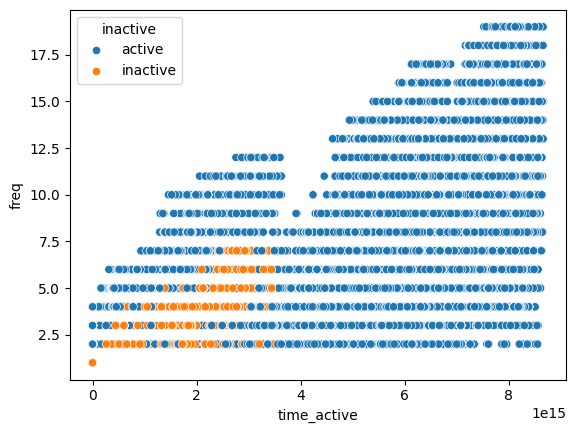

In [22]:
sns.scatterplot(x = 'time_active', y = 'freq', hue = 'inactive', data = timelag)
# improvements:
# x-axis labeling. change it to minutes active
# bar plot takes ages to produce compare to scatterplot

### Average time between votes
calculate the time between vote n and vote n+1

In [23]:
df.head()

voter          vp     created  \
0  0x8847EBaaf29A18396e49191602f8d8D141b98aa7  115.342190  1707436428   
1  0x76154852f74Fb77012d50eedA7D35eA6b2bc3ba9  151.397176  1707436448   
2  0x2cf993715CbA5b83c9a26755EdD42445E900205C    1.127696  1707436497   
3  0x92CBe89B5Cb1c22c2c16Bc465CaF34E3c80b617D    2.053495  1707436516   
4  0x40Fd572771ce7f3B3AFc51e05C2C8288E7d96e5d    1.074772  1707436531   

                                            proposal choice  \
0  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   
1  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   
2  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   
3  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   
4  {'id': '0x07a26cd6b78a41745aab04190f22e97fdf94...      1   

                              space  \
0  {'id': 'arbitrumfoundation.eth'}   
1  {'id': 'arbitrumfoundation.eth'}   
2  {'id': 'arbitrumfoundation.eth'}   
3  {'id': 'arbitrumfoundation.eth'}   
4  {'id': 'arbitrumfoundation.eth'}   

                                                prop                time  rank  
0  0x07a26cd6b78a41745aab04190f22e97fdf9432f56465... 2024-02-08 23:53:48  10.0  
1  0x07a26cd6b78a41745aab04190f22e97fdf9432f56465... 2024-02-08 23:54:08  19.0  
2  0x07a26cd6b78a41745aab04190f22e97fdf9432f56465... 2024-02-08 23:54:57  17.0  
3  0x07a26cd6b78a41745aab04190f22e97fdf9432f56465... 2024-02-08 23:55:16  17.0  
4  0x07a26cd6b78a41745aab04190f22e97fdf9432f56465... 2024-02-08 23:55:31  17.0

In [24]:
df[['time', 'voter', 'rank']].sort_values(['voter', 'rank']).head()

time                                       voter  rank
372019 2023-12-10 18:19:56  0x000000000A38444e0a6E37d3b630d7e855a7cb13   1.0
236087 2024-01-18 17:58:02  0x000000000A38444e0a6E37d3b630d7e855a7cb13   2.0
269381 2024-01-18 17:58:34  0x000000000A38444e0a6E37d3b630d7e855a7cb13   3.0
548912 2023-11-13 22:14:24  0x00000001B01122945D67Cf7c972f1a2063Ca4008   1.0
548861 2023-11-13 21:54:50  0x0000000452Bbfc5541279949E5e9400821A0C92d   1.0

In [25]:
timebtw = df[['time', 'voter', 'rank']].sort_values(['voter', 'rank']).head().groupby('voter').diff()
timebtw = timebtw.rename(columns = {'time': 'timebtw', 'rank':'rankbtw'})

In [29]:
df = df.join(timebtw)


ValueError: columns overlap but no suffix specified: Index(['timebtw', 'rankbtw'], dtype='object')

In [31]:
df.sort_values(['voter', 'time', 'rank']).head()

voter          vp     created  \
372019  0x000000000A38444e0a6E37d3b630d7e855a7cb13  570.002286  1702232396   
236087  0x000000000A38444e0a6E37d3b630d7e855a7cb13  570.002286  1705600682   
269381  0x000000000A38444e0a6E37d3b630d7e855a7cb13  570.002286  1705600714   
548912  0x00000001B01122945D67Cf7c972f1a2063Ca4008   28.533125  1699913664   
548861  0x0000000452Bbfc5541279949E5e9400821A0C92d   20.847620  1699912490   

                                                 proposal  \
372019  {'id': '0xef3ed3b3735cad375953947437980db576ba...   
236087  {'id': '0x1e5052579c5ed931f90e03e59f34274ba0a0...   
269381  {'id': '0xc2d7ebf5ef78084b26544905fd6febf0b825...   
548912  {'id': '0xe968af3f6b06d386958e513c2285f72f7172...   
548861  {'id': '0xe968af3f6b06d386958e513c2285f72f7172...   

                       choice                             space  \
372019              [2, 1, 3]  {'id': 'arbitrumfoundation.eth'}   
236087              [1, 4, 2]  {'id': 'arbitrumfoundation.eth'}   
269381  [2, 9, 10, 6, 23, 24]  {'id': 'arbitrumfoundation.eth'}   
548912                      1  {'id': 'arbitrumfoundation.eth'}   
548861                      1  {'id': 'arbitrumfoundation.eth'}   

                                                     prop                time  \
372019  0xef3ed3b3735cad375953947437980db576baebbba5a0... 2023-12-10 18:19:56   
236087  0x1e5052579c5ed931f90e03e59f34274ba0a006093a6e... 2024-01-18 17:58:02   
269381  0xc2d7ebf5ef78084b26544905fd6febf0b8256293ce7f... 2024-01-18 17:58:34   
548912  0xe968af3f6b06d386958e513c2285f72f7172aabd2661... 2023-11-13 22:14:24   
548861  0xe968af3f6b06d386958e513c2285f72f7172aabd2661... 2023-11-13 21:54:50   

        rank          timebtw  rankbtw  
372019   1.0              NaT      NaN  
236087   2.0 38 days 23:38:06      1.0  
269381   3.0  0 days 00:00:32      1.0  
548912   1.0              NaT      NaN  
548861   1.0              NaT      NaN

In [40]:
# moving average between three entries entries (timelag(n.n1), timelag(n1.n2))
# df['rank'] = df.groupby('voter')['time'].rank(method='first', ascending = True)
df['timebtw'][1]
# import datetime
# datetime.timedelta.total_seconds(df['timebtw'][0])
# df['timebtw'].rolling(min_periods = 3).min()

NaT

In [50]:
# tst = [datetime.timedelta.total_seconds(s) for s in df['timebtw'] if isinstance(s, int)]
for x in df['timebtw']:
    print(x)
    print(pd.isnull(np.datetime64(x)))
# [ s for s in df['timebtw'] if pd.isnull(np.datetime64(s))]
# tst

NaT


TypeError: 'float' object cannot be interpreted as an integer